# Import potřebných balíčků
## Pandas
- Pro vytvoření datasetu a práci s ním
## Matplotlib.pyplot 
- Pro vizualizaci
## Numpy
- Pro výpočty 
## Os
- Pro práci se soubory
## Sklearn.model_selection (train_test_split, GridSearchCV, RandomizedSearchCV)
- Train_test_split -> Slouží k rozdělění dat na trénovací a testovací
- GridSearchCV -> Metoda, která slouží k determinaci nejlepších hyperparametrů (Projede všechny zadané parametry)
- RandomizedSearchCV -> Metoda, která slouží k determinaci nejlepších hyperparamtrů (Náhodně vyzkouší nějaké ze zadaných parametrů)
## Sklearn.ensemble (RandomForestClassifier)
- Model "náhodných lesů", který nám slouží k předpovídaní hodnot
## Sklearn.metrics (classifictaion_report, accuracy_score)
- Classification_report -> Vypíše nám hodnoty klíčových veličin pro hodnocení modelu
- accuracy_score -> Vypíše nám přesnost modelu
## Sklearn.cluster (KMeans, DBSCAN, AgglomerativeClustering)
- KMeans -> Metoda, která určuje shluk na základě podobnosti mezi body - Učení bez učitele
- DBSCAN -> Metoda, která určuje shluk na základě specifikované oblasti kolem bodu - Učení bez učitele
- AgglomerativeClustering -> Metoda, která určuje shluk na základě blízkosti bodů (Na počátku je každý bod jeden shluk), pokračuje dokud nezbyde zadaný počet shluků nebo se všechny nesloučí do jednoho (nemusíme zadávat počet shluků) - Učení bez učitele
## Sklearn.neighbors (KneighborsClassifier)
- KneighborsClassifier -> Metoda, která určuje shluk na základě x sousedících bodech - Shlukovaní s učitelem
## Xgboost
- Knihovna, která mi umožňuje využít model Xgboost 

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


## Funkce pro načtení dat

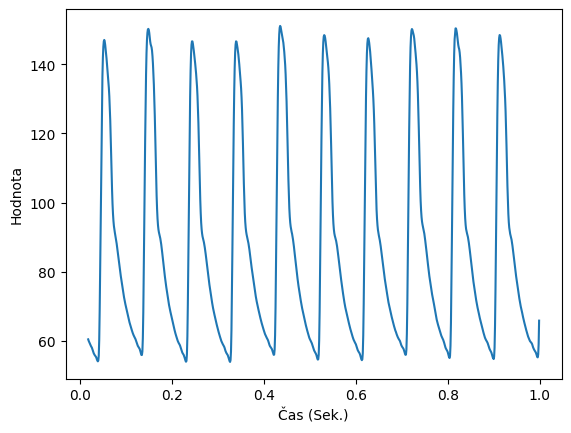

                0
count  982.000000
mean    86.863795
std     30.782831
min     53.913540
25%     61.313540
50%     75.318539
75%    104.751040
max    151.093536


In [6]:
def load_data(dataset, visual, basic_info):
    """ Načte data, vyhodí nan hodnoty a následně vrátí pandas DataFrame a základní info
        dataset - cesta k datasetu
        visual - True/False -> V případě True vykreslí graf hodnot
        basic_info - True/False -> V případě True vypíše základní info
    """
    data = np.loadtxt(dataset)
    data_pd = pd.DataFrame(data).dropna()
    
    if visual == True:
        plt.plot(data_pd.index/1000, data_pd)
        plt.xlabel("Čas (Sek.)")
        plt.ylabel("Hodnota")
        plt.show()
    
    features = data_pd.describe()
    if basic_info == True:
        print(features)
    
    return data_pd, features

x, _ = load_data("dataset_ulricht/abp/TBI_003_abp_0_normal.txt", True, True)

## Funkce pro vytvoření DataFramu, který obsahuje seznam všech měření, jestli v nich je nebo není artefakt a přiřadí k nim základní informace

In [8]:
def generate_measures_dataframe(folder):
    """
    Nejdříve nelezne všechny soubory ve složce a následně z nich udělá DataFrame. 
    DataFrame je následně rozšířen o informaci, zda je měření s artefaktem nebo ne, poté zavolá funkci load_data(),
    která vrátí pro každé měření základní informace a ty pak přidá do DataFramu. Funkce vrací DataFrame.
    
    folder - složka, ve které se nachází jednotlivé měření
    
    
    """
    list_of_measures = os.listdir("dataset_ulricht/" + folder)
    
    # Vytvoření DataFrame s požadovanými sloupci
    pd_measures = pd.DataFrame(columns=["measure_name", "artefact", "count", "mean", "std", "min", "1st_q", "median", "3rd_q", "max"])
    pd_measures["measure_name"] = list_of_measures
    
    # Přiřazení artefaktu na základě názvu souboru
    pd_measures["artefact"] = pd_measures["measure_name"].apply(lambda x: 0 if "normal" in x else 1)
    
    # Hodnoty, které budeme extrahovat z describe
    stats = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]
    
    # Cyklus pro každý soubor a extrakci hodnot
    for idx, measure in enumerate(pd_measures["measure_name"]):
        _, features = load_data("dataset_ulricht/" + folder + "/" + measure, False, False)
        
        # Přiřazení statistických hodnot do DataFrame
        for stat_idx, stat in enumerate(stats):
            pd_measures.iloc[idx, stat_idx + 2] = features.loc[stat][0]  # features.loc[stat][0] je hodnota statistiky
    
    return pd_measures


## Vytvoření datasetu a následně odstranění sloupců, které dle mého nemají vypovídající hodnotu pro učení modelů

In [ ]:
# Zavolání funkce s názvem složky
df = generate_measures_dataframe("abp")

# Odstranění sloupců, které nemají význam pro trénování modelu
X = df.drop(columns=["artefact", "measure_name", "count"])
y = df["artefact"] 

## RandomForest model bez udání parametrů

In [80]:
# Rozdělení dat na trénovací a testovací
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25)

# Vytvoření modelu RandomForest
rf_classifier = RandomForestClassifier()

# Trénování modelu
rf_classifier.fit(X_train, y_train)

# Předpovídání modelu
y_pred = rf_classifier.predict(X_test)

# Vytvoření přehledu o schopnostech modelu
class_rep = classification_report(y_test, y_pred)

# Výpis přesnosti modelu
accuracy1 = accuracy_score(y_test, y_pred)

print("DF1:")
print(class_rep)

print(f"DF1 Accuracy1: {accuracy1}")


DF1:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       345
           1       0.94      0.95      0.94       178

    accuracy                           0.96       523
   macro avg       0.96      0.96      0.96       523
weighted avg       0.96      0.96      0.96       523

DF1 Accuracy1: 0.9617590822179732


## GridSearch, který projde kombinace zadaných parametrů a nakonec vytvoří model na základě nejvhodnějších hyperparametrů
### Tento postup je pomalejší, jelikož prochází všechny možné kombinace hyperparametrů

In [62]:
# Nastavení parametrů, které bude GridSearch zkoušet
parameters = { 
    'n_estimators': [25, 50, 100, 150, 500, 1000], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [None, 1, 2, 3, 6, 9,12], 
    'max_leaf_nodes': [None, 2, 3, 6, 9, 12, 15], 
}

# Vytvoření RandomForest modelu s hledáním hyperparametrů pomocí GridSearch
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=parameters, cv=5)

# Trénovaní modelu
grid_search.fit(X_train, y_train)

print(grid_search.best_estimator_)



C:\Users\Tomáš\AppData\Roaming\Python\Python310\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomForestClassifier(max_features=None, n_estimators=150)


In [63]:
# Predikce
y_pred_grid = grid_search.predict(X_test) 

# Přesnost modelu
accuracy_grid = accuracy_score(y_test, y_pred_grid)

# Vypsání přehledu o schopnostech modelu
print(classification_report(y_test, y_pred_grid)) 
print(f"DF1 Grid Search Accuracy: {accuracy_grid}")

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       345
           1       0.95      0.96      0.95       178

    accuracy                           0.97       523
   macro avg       0.96      0.96      0.96       523
weighted avg       0.97      0.97      0.97       523

DF1 Grid Search Accuracy: 0.9674952198852772


## RandomSearch, který náhodně vybere kombinaci hyperparametrů a následně vytvoří model s těmito hyperparametry
### Tento přístup je rychlejší, protože se neprochází všechny možné kombinace, ale pouze náhodně vybrané kombinace

In [ ]:
# Vytvoření RandomForest modelu, ve kterém používáme pro odhad hyperparametrů RandomizedSearch
random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=parameters, cv=5, n_iter=50)

# Trénování modelu
random_search.fit(X_train, y_train)

# Výpis nejlepších nalezených hyperparametrů
print(random_search.best_estimator_)

# Predikce
y_pred_random = random_search.predict(X_test)

# Přesnost modelu
accuracy_random = accuracy_score(y_test, y_pred_random)

# Vypsání přehledu o schopnostech modelu
print(classification_report(y_test, y_pred_random))
print(f"DF1 Random Search Accuracy: {accuracy_random}")
print(random_search.best_estimator_)

RandomForestClassifier(max_features=None, max_leaf_nodes=15)
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       345
           1       0.94      0.92      0.93       178

    accuracy                           0.95       523
   macro avg       0.95      0.94      0.95       523
weighted avg       0.95      0.95      0.95       523

DF1 Random Search Accuracy: 0.9521988527724665
RandomForestClassifier(max_features=None, max_leaf_nodes=15)


## Shlukování s učitelem
### 1) Nejdříve vytvořím scatter plot, který ukazuje jak by vypadalo "perfektní" shlukování
### 2) Dále vytvořím KNeighbors shlukování, ve kterém zadám, že se shluk má určit podle jeho 5ti sousedů
#### Všechny modely vykresluji do grafu, abych se mohl podívat, jak cca vypadá výsledek a zároveň k nim vypisuji přesnost modelu

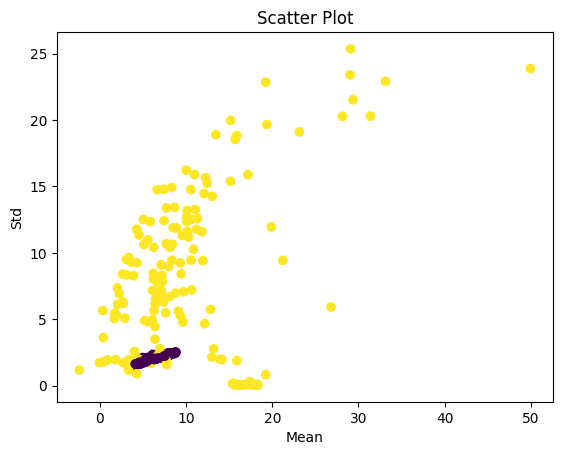

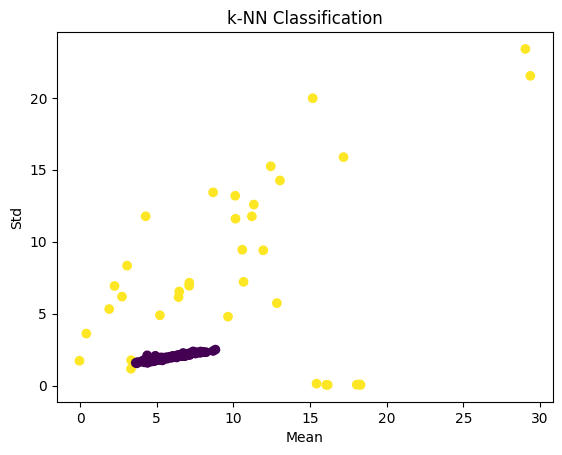

Classification Report for k-NN model:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        92
           1       1.00      0.90      0.95        40

    accuracy                           0.97       132
   macro avg       0.98      0.95      0.96       132
weighted avg       0.97      0.97      0.97       132



In [165]:
# Vytvoření DataFrame
X = generate_measures_dataframe("icp")

# Vykreslení scatterplotu, který zobrazuje, kde se nachází reálné hodnoty "artefact"
plt.scatter(X['mean'], X['std'], c=X['artefact'])
plt.xlabel('Mean')
plt.ylabel('Std')
plt.title('Scatter Plot')
plt.show()

# Vytvoření proměnné se sloupcem, který budu předpovídat
y_artefact = X['artefact']

# Odebrání sloupců, které nejsou pro trénování modelu důležité
X_Kneighbours = X.drop(columns=["artefact", "measure_name", "count"])

# Rozdělení dat na trénovací a testovací
X_train, X_test, y_train, y_test = train_test_split(X_Kneighbours, y_artefact, test_size=0.25, random_state=42)

# Vytvoření KNeighbors modelu
knn = KNeighborsClassifier(n_neighbors=5)

# Trénování modelu
knn.fit(X_train, y_train)

# Predikce
y_pred_knn = knn.predict(X_test)

# Vytvoření scatterplotu pro srovnání, které body model uznal jako artefact = 0/1
plt.scatter(X_test['mean'], X_test['std'], c=y_pred_knn, marker='o', label='Predictions')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.title('k-NN Classification')
plt.show()

# Vypsání přehledu o schopnostech modelu
print("Classification Report for k-NN model:")
print(classification_report(y_test, y_pred_knn))

## Shlukování bez učitele
### 1) Jako první metodu shlukování bez učitelem jsem využil DBSCAN, kterému jsme nastavil oblast pro shluk na 0.5 (přebráno z internetu, zkoušel jsem měnit na 0.1-0.4)
### 2) Druhou metodu jsem zvolil AgglomerativeClustering (Hierarchické shlukování), které jsem nezobrazoval pomocí dendrogramu, jelikož předem znám počet shluků a proto jsem tento parametr i zadal
### 3) Dále vytvořím Kmeans shlukování, ve kterém zadám počet shluků, jelikož vím, že shluky musí být dva
#### Pro všechny modely vykresluji graf a změřím přesnost modelu 

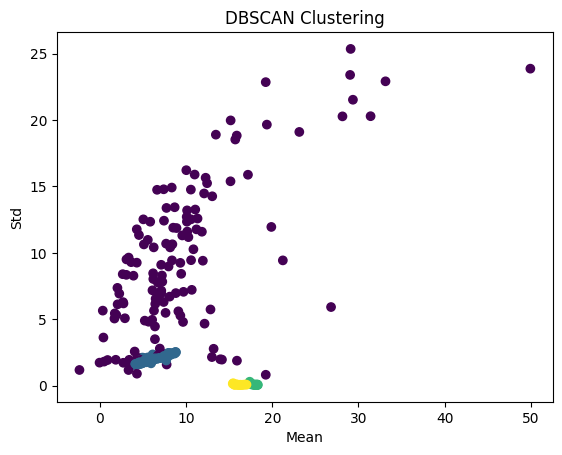

DBSCAN Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.97      1.00      0.98       352
           1       1.00      0.09      0.16       176
           2       0.00      0.00      0.00         0

    accuracy                           0.70       528
   macro avg       0.49      0.27      0.29       528
weighted avg       0.98      0.70      0.71       528



C:\Users\Tomáš\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Tomáš\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Tomáš\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


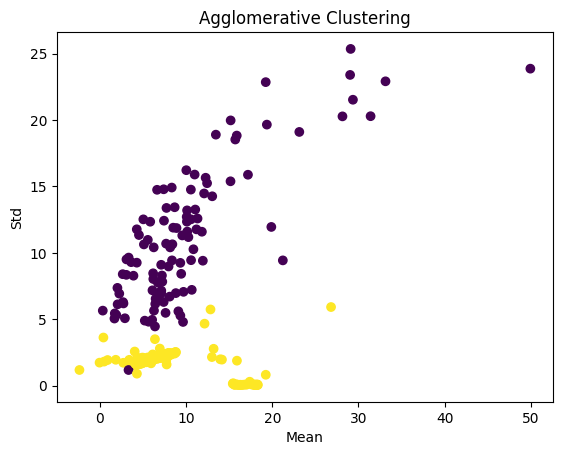

Agglomerative Clustering Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       352
           1       0.17      0.40      0.24       176

    accuracy                           0.13       528
   macro avg       0.08      0.20      0.12       528
weighted avg       0.06      0.13      0.08       528



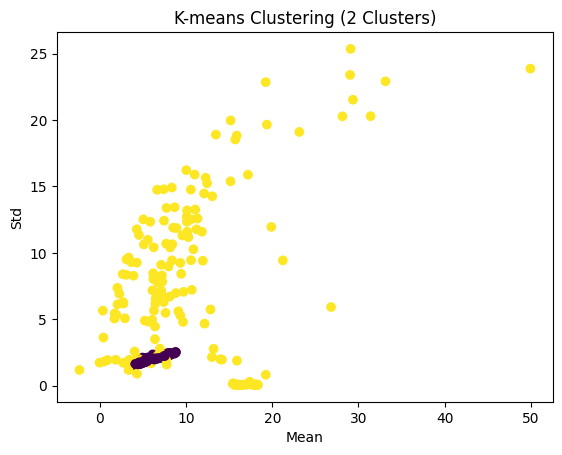

K-Means Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       352
           1       1.00      0.52      0.69       176

    accuracy                           0.84       528
   macro avg       0.90      0.76      0.79       528
weighted avg       0.87      0.84      0.82       528



In [168]:
# Vytvoření DataFrame
X = generate_measures_dataframe("icp")

# Vytvoření proměnné, kterou budu predikovat
y_real = X['artefact']

# Odebrání nepotřebných sloupců pro trénování modelu
X = X.drop(columns=['measure_name', 'artefact', 'count'])

# Vytvoření DBSCAN modelu
dbscan = DBSCAN(eps=1, min_samples=5)

# Trénování a predikce
y_pred_dbscan = dbscan.fit_predict(X)

# Vytvoření scatterplotu pro srovnání, jaké body model vyhodnotil jako artefact = 0/1
plt.scatter(X['mean'], X['std'], c=y_pred_dbscan)
plt.xlabel('Mean')
plt.ylabel('Std')
plt.title('DBSCAN Clustering')
plt.show()

# Vypsání přehledu o schopnostech modelu
print("DBSCAN Classification Report:")
print(classification_report(y_real, y_pred_dbscan))

# Vytvoření modelu AgglomerativeClustering, s přiřazením 2 shluků
agg_clust_model = AgglomerativeClustering(n_clusters=2)

# Trénování a predikce 
y_pred_agg = agg_clust_model.fit_predict(X)

# Vytvoření scatterplotu pro srovnání, jaké body model vyhodnotil jako artefact = 0/1
plt.scatter(X['mean'], X['std'], c=y_pred_agg)
plt.xlabel('Mean')
plt.ylabel('Std')
plt.title('Agglomerative Clustering')
plt.show()

# Vypsání přehledu o schopnostech modelu
print("Agglomerative Clustering Classification Report:")
print(classification_report(y_real, y_pred_agg))

# Vytvoření modelu KMeans
kmeans = KMeans(n_clusters=2, random_state=42)

# Trénování a predicke
y_pred_kmeans = kmeans.fit_predict(X)

# Vytvoření scatterplotu pro srovnání, jaké body model vyhodnotil jako artefact = 0/1
plt.scatter(X['mean'], X['std'], c=y_real)
plt.xlabel('Mean')
plt.ylabel('Std')
plt.title('K-means Clustering (2 Clusters)')
plt.show()

# Vypsání přehledu o schopnostech modelu
print("K-Means Classification Report:")
print(classification_report(y_real, y_pred_kmeans))

## XGBoost
### Vysoce efektivní model, který se využívá pro úkoly klasifikace, regrese a další
### Je založen na myšlence "boosting" -> Model se trénuje sekvenčně a každý nový model se zaměřuje na chyby modelu předchozího

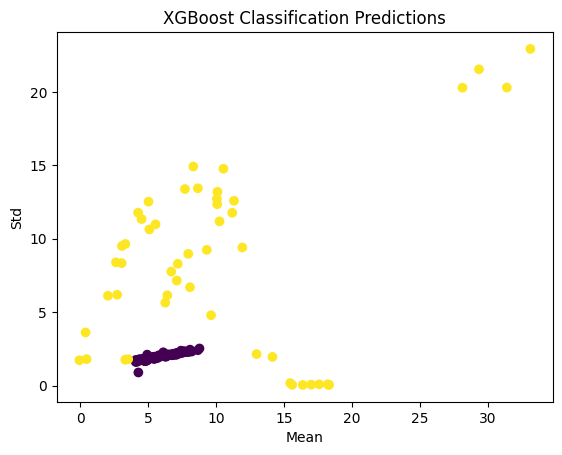

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        81
           1       1.00      0.98      0.99        51

    accuracy                           0.99       132
   macro avg       0.99      0.99      0.99       132
weighted avg       0.99      0.99      0.99       132



In [171]:
# Vytvoření DataFrame
X = generate_measures_dataframe("icp")

# Vytvoření proměnné, kterou budu predikovat
y = X['artefact']

# Odstranění proměnných, které nejsou potřeba pro trénování modelu
X = X.drop(columns=['artefact', 'measure_name', 'count'])

# Převedení na numerické hodnoty (Bez tohoto jsem dostával errory)
X = X.apply(pd.to_numeric, errors='coerce')

# Rozdělení dat na trénovací a testovací
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Převedení dat na DMatrix (Dle dohledaných informací se toto má dělat a zároveň jsem bez toho měl errory)
xgb_train = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Zadání parametrů pro XGBoost
params = {
    'objective': 'binary:hinge',
    'max_depth': 2,
    'learning_rate': 0.01,
}

# Trénování modelu
model = xgb.train(params=params, dtrain=xgb_train)

# Predikce
preds = model.predict(xgb_test)
preds = preds.astype(int)

# Vytvoření scatterplotu pro srovnání, jaké body model vyhodnotil jako artefact = 0/1
plt.scatter(X_test['mean'], X_test['std'], c=preds, cmap='viridis', marker='o', label='Predictions')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.title('XGBoost Classification Predictions')
plt.show()

# Vypsání přehledu o schopnostech modelu
print(classification_report(y_test, preds))


# Výsledné shrnutí
## Z modelů, které jsem použil, tak průměrně lepších výsledků dosáhly modely s učitelem. 
### Nejlépe dopadl "XGBoost", který dosáhl až 99% přesnosti. 
### Z modelů bez učitele nejlépe dopadl "K-Means", který dosáhl přesnosti 84%.
## Z mého pozorování a použitých veličin (průměr, standardní odchylka, minimum, maximum), že pro tento případ se více hodí modely, které pracují s učitelem, jelikož dosáhli lepších výsledků. 